In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install pyro-ppl
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
!git clone https://github.com/ArikReuter/PFNExperiments


Cloning into 'PFNExperiments'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 266 (delta 152), reused 185 (delta 75), pack-reused 0
Receiving objects: 100% (266/266), 2.17 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [4]:
import torch

In [5]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_plain, make_lm_program_gamma_gamma, make_lm_program_gamma_gamma_augmented
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.LinearRegression.Models.Transformer import Transformer
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed, nll_loss_full_gaussian
from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian

from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison
from PFNExperiments.LinearRegression.Models.ModelToPosterior import ModelToPosterior
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

In [9]:
pprogram1 = make_lm_program_plain(
    sigma_squres = 0.01
)
pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)


TypeError: make_lm_program_plain() got an unexpected keyword argument 'sigma_squres'

In [10]:
N = 50
P = 10
BATCH_SIZE = 1024
#BATCH_SIZE = 128

100%|██████████| 1000/1000 [00:00<00:00, 1477.35it/s]


Discarded 0 samples
{'X': {'mean': tensor(0.4998), 'variance': tensor(0.0834), 'min': tensor(2.2054e-06), 'max': tensor(1.0000)}, 'y': {'mean': tensor(0.0140), 'variance': tensor(1.0140), 'min': tensor(-4.3795), 'max': tensor(5.5849)}, 'beta': {'mean': tensor([-0.0067,  0.0365, -0.0041]), 'variance': tensor([1.0325, 1.0034, 1.0452]), 'min': tensor([-3.0238, -3.3463, -4.2357]), 'max': tensor([3.4167, 3.1137, 3.1621])}}


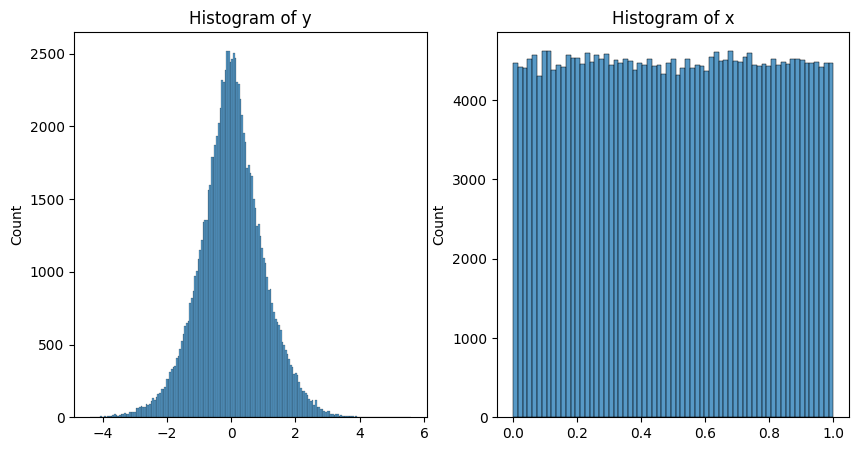

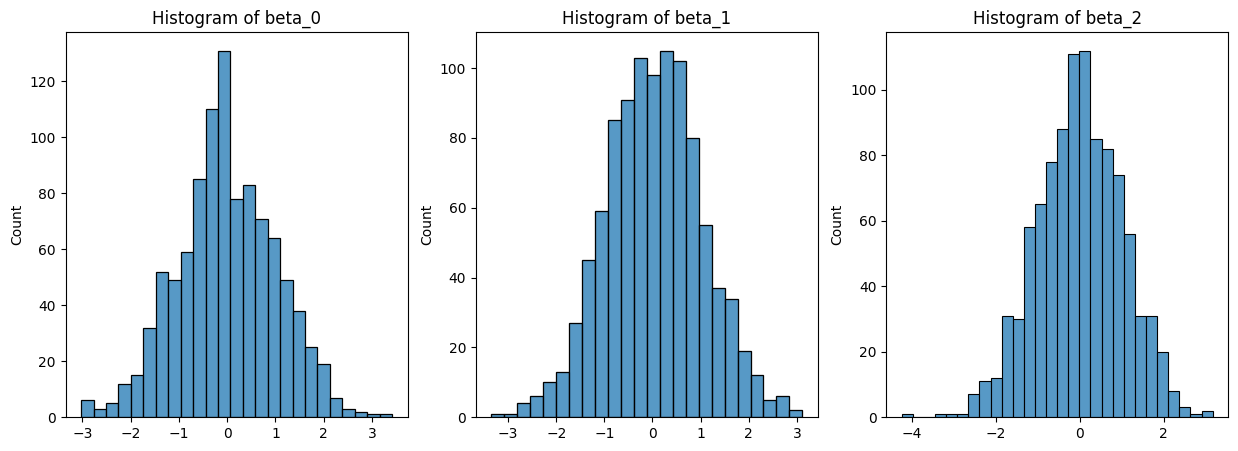

In [11]:
generator = GenerateData(pprogram1)
generator.render_model()
_ = generator.check_model()

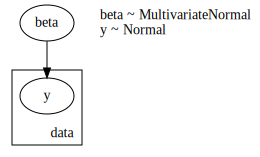

In [12]:
generator.render_model(p = P)

In [13]:
train_loader, test_loader, val_loader = generator.make_dataloaders_dynamic(
    n = N,
    p = P,
    n_batch =500_000,
    #n_batch =10_000,
    batch_size = BATCH_SIZE,
    val_frac = 0.1,
    train_frac = 0.5
)

In [14]:
"""
model = Transformer(
    n_features= P+1,
    seq_len= N,
    d_model= 1024,
    n_heads=4,
    dim_feedforward=512,
    n_layers=4,
    n_skip_layers_final_heads = 3,
    n_output_units_per_head=[5]
).cuda()
"""

model = Transformer(
    n_features= P+1,
    seq_len= N,
    d_model= 512,
    n_heads= 8,
    dim_feedforward=1024,
    dropout_rate = 0.1,
    n_layers=4,
    n_skip_layers_final_heads = 4,
    n_output_units_per_head=[P, P*P, P]
).cuda()

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
'{:.2e}'.format(count_parameters(model))

'3.33e+07'

In [17]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [18]:
mod_posterior = ModelPosteriorFullGaussian(cov_reg_factor = 1e-4)
nll_loss = mod_posterior.negative_log_likelihood
nll_loss_avg = ModelPosteriorFullGaussian(cov_reg_factor = 1e-4).negative_log_likelihood_avg
nll_loss_std = ModelPosteriorFullGaussian(cov_reg_factor = 1e-4).negative_log_likelihood_std
nll_loss_median = ModelPosteriorFullGaussian(cov_reg_factor = 1e-4).negative_log_likelihood_median

In [19]:
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [20]:
scheduler = ReduceLROnPlateau(opt, patience = 10)

additional_evals = {
    "loss": nll_loss_avg,
    "loss median": nll_loss_median,
    "loss_std": nll_loss_std
}


In [21]:
model = model.cuda()

In [22]:
trainer = Trainer(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=nll_loss,
    trainset = train_loader,
    testset = test_loader,
    valset=val_loader,
    evaluation_functions= additional_evals,
    n_epochs = 200,
    early_stopping_patience = 20
)

In [23]:
trainer.save_path

'../models/model.pth'

In [24]:
trainer.validate()

100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


{'loss': tensor(636.7051),
 'loss median': 637.48224,
 'loss_std': tensor(16.6029)}

In [ ]:
r = trainer.train()

100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


Epoch 0:
Training: {'loss': tensor(15.5529), 'loss median': 15.481712, 'loss_std': tensor(1.6656)}
Validation: {'loss': tensor(12.4958), 'loss median': 12.489268, 'loss_std': tensor(0.0813)}
Time: 332.8667335510254
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


Epoch 1:
Training: {'loss': tensor(7.8248), 'loss median': 7.1765, 'loss_std': tensor(2.4775)}
Validation: {'loss': tensor(3.3290), 'loss median': 3.3364272, 'loss_std': tensor(0.1133)}
Time: 335.5408442020416
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


Epoch 2:
Training: {'loss': tensor(0.7468), 'loss median': 0.17967564, 'loss_std': tensor(1.6328)}
Validation: {'loss': tensor(-1.3126), 'loss median': -1.3240108, 'loss_std': tensor(0.1272)}
Time: 335.21972608566284
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


Epoch 3:
Training: {'loss': tensor(-1.5314), 'loss median': -1.6271156, 'loss_std': tensor(0.7907)}
Validation: {'loss': tensor(-4.0061), 'loss median': -3.9931855, 'loss_std': tensor(0.1027)}
Time: 334.7168004512787
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 49/49 [00:38<00:00,  1.26it/s]


Epoch 4:
Training: {'loss': tensor(-1.9715), 'loss median': -2.2931993, 'loss_std': tensor(1.1192)}
Validation: {'loss': tensor(-2.3407), 'loss median': -2.319487, 'loss_std': tensor(0.1233)}
Time: 336.32907915115356
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


Epoch 5:
Training: {'loss': tensor(-2.8435), 'loss median': -3.1079593, 'loss_std': tensor(0.8922)}
Validation: {'loss': tensor(-5.4648), 'loss median': -5.466775, 'loss_std': tensor(0.1162)}
Time: 334.7102780342102
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 49/49 [00:39<00:00,  1.25it/s]


Epoch 6:
Training: {'loss': tensor(-2.9590), 'loss median': -3.2177417, 'loss_std': tensor(0.9458)}
Validation: {'loss': tensor(-2.6901), 'loss median': -2.6825588, 'loss_std': tensor(0.0911)}
Time: 335.4937014579773
Learning rate: [0.0001]


----------------------------------------------------------------------------------------------------


 99%|█████████▉| 242/245 [04:50<00:03,  1.21s/it]

In [ ]:
visualize_training_results(r, loglog = False)

In [ ]:
trainer.load_best_model()

In [ ]:
model = trainer.model

In [ ]:
model.eval()

In [ ]:
trainer.load_best_model()

In [ ]:
trainer.model.cuda()

In [ ]:
trainer.test()

In [ ]:
full_model = ModelToPosterior(model.cpu(), mod_posterior)

In [ ]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=400, n_samples=400)

comparison_model = ModelComparison(
    modelposterior=full_model,
    comparison_model=hmc_sampler,
)


In [ ]:
test_batch = next(iter(test_loader))

In [ ]:
test_batch["beta"][:3]

In [ ]:
r_hmc = comparison_model.compare_sample_metrics_batch(test_batch["x"][:5].cpu(), test_batch["y"][:5].cpu())

In [ ]:
r_hmc

In [ ]:
print(r_hmc[0])

In [ ]:
guide_gamma_gamma = make_guide_program_gamma_gamma()

In [ ]:
vi = Variational_Inference(
    pprogram=pprogram1,
    guide = guide_gamma_gamma,
    n_steps = 2000,
    n_samples=10_000,
    lr = 1e-1
)

In [ ]:
comparison_model2 = ModelComparison(
    modelposterior=full_model,
    comparison_model=vi
)
r_vi = comparison_model2.compare_sample_metrics_batch(test_batch["x"][:5].cpu(), test_batch["y"][:5].cpu())

In [ ]:
print(r_vi)

In [ ]:
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

In [ ]:
comparison_model_comparer = CompareComparisonModels(
    comparison_model_1=vi,
    comparison_model_2=hmc_sampler,
    n_samples_comparison_model_1=1000
)

In [ ]:
comparison_model_comparer.compare_sample_metrics_batch(test_batch["x"][:5], test_batch["y"][:5])